# CAICT 風機結冰預測 - Baseline

2017/07/23  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

### Summary

### Outline

## 1. Load Data and Modules

**Load Python modules:**

In [33]:
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import matplotlib.pyplot as plt
import shutil
import csv
import sklearn as sk
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline
pd.set_option('display.max_columns', None)
#InteractiveShell.ast_node_interactivity = "all"

In [34]:
def variable_summaries(var, name):  
    with tf.name_scope('summaries_'+str(name)):  
        mean = tf.reduce_mean(var)  
        tf.summary.scalar('mean', mean)  
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))  
        tf.summary.scalar('stddev', stddev)  
        tf.summary.scalar('max', tf.reduce_max(var))  
        tf.summary.scalar('min', tf.reduce_min(var))  
        tf.summary.histogram('histogram', var)  
        
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()
    



In [35]:
def variable_selection(data, isTest=False):
    if isTest:
        fixed_variable = ['time','group']
    else:
        fixed_variable = ['label','event','time','group','timestamp']
    #selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed']
    selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed','power','yaw_position','environment_tmp']
    variable = selected_variable + fixed_variable 
    data = data[variable]
    return data

def load_resample_data(id, remove_unknown=True, split_case=20, split_validation=True, policy=1, varsel=False, label=None):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    if varsel:
        data_resample=variable_selection(data_resample)
    
    if remove_unknown:
        data_resample = data_resample[data_resample['label']!=2]
    
    if label is not None:
        data_resample = data_resample[data_resample['label']==label]
    
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]

    train_aX = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    train_ay = data_resample['label']
    train_aY = np.eye(2)[train_ay.values.astype(int)]
    
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1)
    train_y = data_resample_train['label']
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1)
    valid_y = data_resample_valid['label']
    train_Y = np.eye(2)[train_y.values.astype(int)]
    valid_Y = np.eye(2)[valid_y.values.astype(int)]

    train_abnormal = data_resample_train[data_resample_train['label']==1]
    train_normal = data_resample_train[data_resample_train['label']==0]
    train_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(train_normal), j=len(train_normal)/len(data_resample_train),k=len(train_abnormal),m=len(train_abnormal)/len(data_resample_train), n=len(data_resample_train))
    
    valid_abnormal = data_resample_valid[data_resample_valid['label']==1]
    valid_normal = data_resample_valid[data_resample_valid['label']==0]
    valid_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(valid_normal), j=len(valid_normal)/len(data_resample_valid),k=len(valid_abnormal),m=len(valid_abnormal)/len(data_resample_valid), n=len(data_resample_valid))
    if split_validation:
        return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc
    else:
        return data_resample, train_aX, train_aY, train_ay

def load_test1_data(id,remove_unknown=True, dropna=True, varsel=False):
    filename = 'data/goodformat_{ID}.csv'.format(ID=id)
    data_raw = pd.read_csv(filename)
    if varsel:
        data_raw=variable_selection(data_raw)
        
    if dropna:
        data_raw = data_raw.dropna()
    else: 
        data_raw = data_raw.fillna(0)
        
    data_X = data_raw.drop(['label','time','group','timestamp'], axis=1).values
    data_y = data_raw['label'].values.astype(int)
    data_Y = np.eye(2)[data_y]
    
    data_abnormal = data_raw[data_raw['label']==1]
    data_normal = data_raw[data_raw['label']==0]
    data_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(data_normal), j=len(data_normal)/len(data_raw),k=len(data_abnormal),m=len(data_abnormal)/len(data_raw), n=len(data_raw))
    
    return data_raw, data_X, data_Y, data_y, data_desc

def load_test2_data(varsel=False):
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    if varsel:
        test_data=variable_selection(test_data,isTest=True)
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp.values
    return test_data, test_X, test_timeidx


**Load input data.** 

In [36]:
resample_policy=1
train_raw, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc = load_resample_data(id=15,policy=resample_policy,varsel=False)
valid_raw, valid_21_X, valid_21_Y, valid_21_y,= load_resample_data(id=21,policy=resample_policy,split_validation=False,split_case=8,varsel=False)
test_raw, test_X,test_timeidx = load_test2_data(varsel=False)



**風機15 Training/Validation Data 狀態正常(0)/異常(1)比例 **

In [37]:
print('15-train:', train_desc)
print('15-valid:',valid_desc)

15-train: 正常:35339 (0.61 percent), 結冰:22179 (0.39 percent), Total:57518
15-valid: 正常:7680 (0.64 percent), 結冰:4315 (0.36 percent), Total:11995


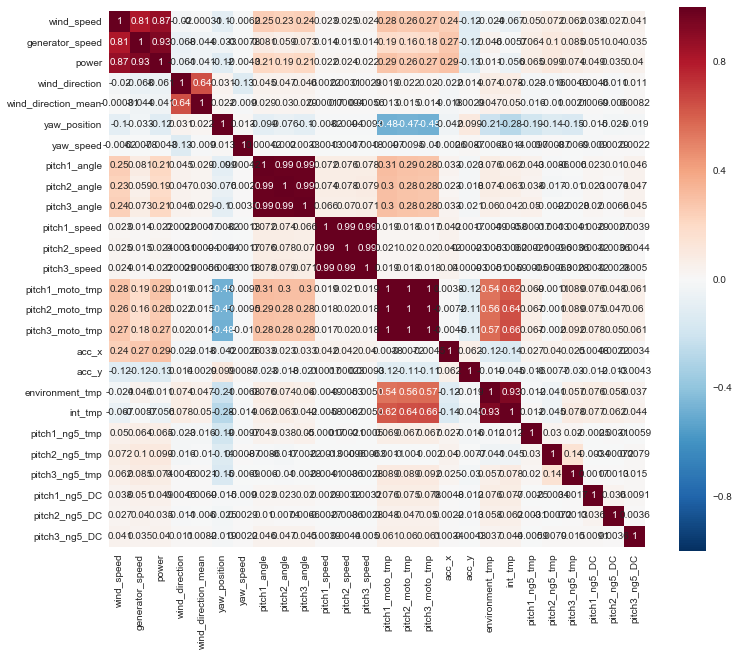

In [38]:
ax = plt.subplots( figsize =( 12 , 10 ) )
sns.heatmap(train_X.corr(), vmax=1.0, square=True, annot=True)

<a id='Modeling'></a>
## 2. Modeling

** Test and select the model features **

In [39]:
X = train_X
y = train_y

#valid_X
#valid_y,

In [40]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(train_X,train_y)
score_log = clf_log.score(X,y)
print('Training Data Accuracy:',score_log)

Training Data Accuracy: 0.861591154074


In [72]:
print('Feature Importance:')

fea = pd.DataFrame(list(zip(X.columns, np.transpose(clf_log.coef_))), columns=['feature','weight'])
fea['abs'] = abs(fea['weight'])
fea.sort_values(by='abs', ascending=False)

Feature Importance:


,feature,weight,abs
8,pitch2_angle,[19.588876783],[19.588876783]
9,pitch3_angle,[-15.0869485944],[15.0869485944]
15,pitch3_moto_tmp,[10.7204090658],[10.7204090658]
13,pitch1_moto_tmp,[-7.31515968002],[7.31515968002]
2,power,[-6.88106757339],[6.88106757339]
18,environment_tmp,[-3.56291089067],[3.56291089067]
0,wind_speed,[3.01763161317],[3.01763161317]
14,pitch2_moto_tmp,[-2.34680220551],[2.34680220551]
7,pitch1_angle,[-2.19897201683],[2.19897201683]
1,generator_speed,[2.0349533359],[2.0349533359]


In [42]:
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    prec= precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y)
    accuracy = accuracy_score(true_y,pred_y)
    confusions = (
    ('tn', tn),
    ('fn', fn),
    ('tp', tp),
    ('fp', fp)
    )
    msg = 'Score:{sco} \n\taccuracy:{acc}, \n\trecall:{rcl}, \n\tprecision:{psc}\n\t{cfmt}'.format(sco=score,acc=accuracy,rcl=recall,psc=prec,cfmt=confusions)
    return score, accuracy, prec, recall, OrderedDict(confusions),msg


** 1. Logistic Regression **

In [43]:
model_log = LogisticRegression()
model_log = model_log.fit(train_X,train_y)
pred_y = model_log.predict(valid_X)
score_log, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.7416373207560835 
	accuracy:0.7289704043351396, 
	recall:0.7867902665121669, 
	precision:0.5929095354523227
	(('tn', 5349), ('fn', 920), ('tp', 3395), ('fp', 2331))


** 2. Perceptron**

In [44]:
model_prcp = Perceptron(
    class_weight='balanced'
    )
model_prcp = model_prcp.fit(train_X,train_y)
pred_y = model_prcp.predict(valid_X)
score_pctr, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.7277631928350715 
	accuracy:0.7005418924551896, 
	recall:0.8247972190034762, 
	precision:0.5565285379202501
	(('tn', 4844), ('fn', 756), ('tp', 3559), ('fp', 2836))


** 3. K Nearest Neighbours **

In [45]:
model_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
model_knn = model_knn.fit(train_X,train_y)
pred_y = model_knn.predict(valid_X)
score_knn, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.680226212461375 
	accuracy:0.6765318882867861, 
	recall:0.6933951332560835, 
	precision:0.5391962515768607
	(('tn', 5123), ('fn', 1323), ('tp', 2992), ('fp', 2557))


**4. Support Vector Machine**

In [46]:
model_svm = svm.SVC(
    class_weight='balanced'
    )
model_svm = model_svm.fit(train_X,train_y)
pred_y = model_svm.predict(valid_X)
score_svm, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.5945432448580533 
	accuracy:0.6748645268862026, 
	recall:0.3082271147161066, 
	precision:0.5924276169265034
	(('tn', 6765), ('fn', 2985), ('tp', 1330), ('fp', 915))


**5. Bagging**

In [47]:
model_bag = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )

model_bag = model.fit(train_X,train_y)
pred_y = model_bag.predict(valid_X)
#score_bag = clf_bag.oob_score_
score_bag, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)


Score:0.7300754846224411 
	accuracy:0.7503126302626094, 
	recall:0.6579374275782155, 
	precision:0.6514456172556219
	(('tn', 6161), ('fn', 1476), ('tp', 2839), ('fp', 1519))


**6. Decision Tree**

In [48]:
model_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
model_tree = model_tree.fit(train_X,train_y)
pred_y = model_tree.predict(valid_X)
score_tree, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.6759394463354577 
	accuracy:0.6451021258857857, 
	recall:0.7858632676709154, 
	precision:0.5043129089827484
	(('tn', 4347), ('fn', 924), ('tp', 3391), ('fp', 3333))


**6. Random Forest**

In [49]:
model_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
model_rf = model_rf.fit(train_X,train_y)
pred_y = model_rf.predict(valid_X)
score_rf, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.5994463505455774 
	accuracy:0.6537724051688203, 
	recall:0.40579374275782154, 
	precision:0.524251497005988
	(('tn', 6091), ('fn', 2564), ('tp', 1751), ('fp', 1589))


** Extremely Randomised Trees**

In [50]:
model_etrtree = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
model_etrtree = model_etrtree.fit(train_X,train_y)
pred_y = model_etrtree.predict(valid_X)
score_ext, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.6459017568317884 
	accuracy:0.6711963318049187, 
	recall:0.5557358053302434, 
	precision:0.5419209039548023
	(('tn', 5653), ('fn', 1917), ('tp', 2398), ('fp', 2027))


**Gradient Boosting:**

In [51]:
import warnings
warnings.filterwarnings("ignore")

model_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0).fit(X, y)
model_gb = model_gb.fit(train_X,train_y)
pred_y = model_gb.predict(valid_X)
score_gb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.658501940300309 
	accuracy:0.6948728636932056, 
	recall:0.5288528389339513, 
	precision:0.5837810181632132
	(('tn', 6053), ('fn', 2033), ('tp', 2282), ('fp', 1627))


** Ada Boost:**

In [52]:
model_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
model_ada = model_ada.fit(train_X,train_y)
pred_y = model_ada.predict(valid_X)
score_ada, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.737457980277134 
	accuracy:0.7578157565652355, 
	recall:0.6648899188876014, 
	precision:0.6628927911275416
	(('tn', 6221), ('fn', 1446), ('tp', 2869), ('fp', 1459))


**eXtreme Gradient Boosting:**

In [53]:
model_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
model_xgb = model_xgb.fit(train_X,train_y)
pred_y = model_xgb.predict(valid_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.7300754846224411 
	accuracy:0.7503126302626094, 
	recall:0.6579374275782155, 
	precision:0.6514456172556219
	(('tn', 6161), ('fn', 1476), ('tp', 2839), ('fp', 1519))


### Ranking of models and features

In [77]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Gradient Boosting', 'Bagging', 
              'Decision Tree','XGBoost','ExtraTree','Perceptron','Ada Boost'],
    'Score': [score_svm, score_knn, score_log, score_rf, score_gb, score_bag,
              score_tree,score_xgb,score_ext,score_pctr,score_ada]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Logistic Regression,0.741637
10,Ada Boost,0.737458
5,Bagging,0.730075
7,XGBoost,0.730075
11,Bagging,0.730075
9,Perceptron,0.727763
1,KNN,0.680226
6,Decision Tree,0.675939
4,Gradient Boosting,0.658502
8,ExtraTree,0.645902


In [74]:
summary = pd.DataFrame(list(zip(X.columns, \
    np.transpose(model_log.coef_), \
    np.transpose(model_prcp.coef_), \
#    np.transpose(model_knn.feature_importances_), \
    np.transpose(model_tree.feature_importances_), \
    np.transpose(model_rf.feature_importances_), \
    np.transpose(model_etrtree.feature_importances_), \
    np.transpose(model_gb.feature_importances_), \
    np.transpose(model_ada.feature_importances_), \
    np.transpose(model_xgb.feature_importances_), \
#    np.transpose(model_svm.coef_), \
    np.transpose(model_bag.feature_importances_), \
    )), columns=['Feature','LogisticRegression','Perceptron','Tree','RF','Extra','GB','Ada','Xtreme','Bagging'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,LogisticRegression,Perceptron,Tree,RF,Extra,GB,Ada,Xtreme,Bagging,Median
18,environment_tmp,[-3.56292065943],[-28.7879304041],0.290878,0.167008,0.156380,0.148667,0.1925,0.171214,0.171214,0.171214
5,yaw_position,[-0.14911760769],[4.02025937977],0.176316,0.093768,0.078948,0.099749,0.1350,0.133697,0.133697,0.133697
2,power,[-6.88134349346],[-52.0530462992],0.295759,0.117517,0.096261,0.063252,0.1400,0.118690,0.118690,0.118690
19,int_tmp,[1.77483763985],[14.6194337277],0.041305,0.102237,0.098764,0.108605,0.0725,0.096180,0.096180,0.096180
9,pitch3_angle,[-15.0866195093],[-125.167957433],0.016564,0.065290,0.075951,0.060054,0.1000,0.091405,0.091405,0.075951
8,pitch2_angle,[19.5889423867],[150.991838116],0.078289,0.062493,0.066605,0.067633,0.0775,0.058663,0.058663,0.066605
14,pitch2_moto_tmp,[-2.3466427129],[-31.7358549943],0.039092,0.069072,0.061533,0.064684,0.0400,0.084584,0.084584,0.064684
15,pitch3_moto_tmp,[10.720562838],[87.8271032236],0.035419,0.066289,0.062815,0.061056,0.1100,0.054570,0.054570,0.061056
7,pitch1_angle,[-2.1991747643],[-13.1879337114],0.003413,0.052714,0.067226,0.046127,0.0350,0.066849,0.066849,0.052714
13,pitch1_moto_tmp,[-7.31548826599],[-51.950637171],0.007989,0.066226,0.060493,0.030713,0.0275,0.048431,0.048431,0.048431


### Optimising one classifier in more detail:

In [ ]:
clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              'n_estimators': [100, 500,1000],
              'booster': ['gbtree', 'gblinear', 'dart']}
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              'n_estimators': [100, 500,1000],
              'booster': ['gbtree', 'gblinear', 'dart']}
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='recall', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              'n_estimators': [100, 500,1000],
              'booster': ['gbtree', 'gblinear', 'dart']}
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='precision', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf_xgb = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    booster='gbtree',
    n_estimators=50
    )
clf_xgb = clf_xgb.fit(train_X,train_y)
score_xgb = clf_xgb.score(valid_X, valid_y)
print(score_xgb)
pd.DataFrame(list(zip(X.columns, np.transpose(clf_xgb.feature_importances_))) \
            ).sort_values(1, ascending=False)

In [ ]:
scores = cross_val_score(clf_xgb, train_X,train_y, cv=5)
print(scores)
print("Mean score(train) = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))

In [ ]:
score_ext_test= cross_val_score(clf_xgb, valid_X,valid_y, cv=5)
print(score_ext_test)
print("Mean score(validation) = %.3f, Std deviation = %.3f"%(np.mean(score_ext_test),np.std(score_ext_test)))

### Stacking / Ensemble methods

In [ ]:
2	Logistic Regression	0.741637
10	Ada Boost	0.737458
5	Bagging	0.730075
7	XGBoost	0.730075
11	Bagging	0.730075
9	Perceptron	0.727763

1	KNN	0.680226
6	Decision Tree	0.675939
4	Gradient Boosting	0.658502
8	ExtraTree	0.645902
3	Random Forest	0.599446
0	Support Vector Machines	0.594543

In [ ]:
clf_vote = VotingClassifier(
    estimators=[
        ('logistic', model_log),
        ('ada', model_ada),
        ('bag', model_bag),
        ('xgb', model_xgb),
        ('percep', model_prcp),
        ('knn', model_knn),
        ('svm', model_svm),
        ('extra', model_etrtree),
        ('gb', model_gb),
        ('RF', model_rf),
        ('tree', model_tree)
        ],
    weights=[2,2,2,2,2,1,1,1,1,1,1],
    voting='hard')
clf_vote.fit(train_X,train_y)

scores = cross_val_score(clf_vote, train_X,train_y, cv=5, scoring='accuracy')
print("Voting: Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
